In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user_embed = nn.Embedding(nb_users, mf_dim)
        self.mf_item_embed = nn.Embedding(nb_items, mf_dim)
        self.mlp_user_embed = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.mlp_item_embed = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        self.dropout = dropout
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot
        self.mf_user_embed.weight.data.normal_(0., 0.01)
        self.mf_item_embed.weight.data.normal_(0., 0.01)
        self.mlp_user_embed.weight.data.normal_(0., 0.01)
        self.mlp_item_embed.weight.data.normal_(0., 0.01)
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        xmfu = self.mf_user_embed(user)
        xmfi = self.mf_item_embed(item)
        xmf = xmfu * xmfi

        xmlpu = self.mlp_user_embed(user)
        xmlpi = self.mlp_item_embed(item)
        xmlp = torch.cat((xmlpu, xmlpi), dim=1)
        for i, layer in enumerate(self.mlp):
            xmlp = layer(xmlp)
            xmlp = nn.functional.relu(xmlp)
            if self.dropout != 0:
                xmlp = nn.functional.dropout(xmlp, p=self.dropout, training=self.training)

        x = torch.cat((xmf, xmlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [4]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this!
        #Sample neg users
        USER,ITEM=0,1
        neg_users = ratings[:,USER].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,USER], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,ITEM]).repeat(self.negative_samples).random_(0,max_item)
        self.items = torch.cat((ratings[:,ITEM], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,ITEM], dtype=torch.float32).repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,ITEM], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [8]:
def train_model(criterion, optimizer, train_file, test_file, num_epochs=50):
    # users_num = 943 + 1
    # movies_num = 1682 + 1

    ds_train = ML100kDataset(train_file, 2)
    ds_test = ML100kDataset(test_file, 2)
    # create a data loader for train and test sets
    train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
    test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)
    # model = NeuMF(users_num,movies_num,16,[128,64,32])

    test_loss = []
    train_loss = []
    for epoch in range(num_epochs):
        model.train()
        tr_loss=[]
        if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == num_epochs - 1:
            print("Epoch "+str(epoch+1))
        for (u,i,l) in train_dl:
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(u,i,sigmoid=True)
            l = l.unsqueeze(1)
            # calculate loss
            loss = criterion(yhat, l)
            tr_loss.append(loss.detach().numpy())
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        train_loss.append(np.mean(tr_loss))
        model.eval()
        predictions = []
        with torch.no_grad():
            t_loss=[]
            for i, (u,i,l) in enumerate(test_dl):
                yhat = model(u, i, sigmoid=True)
                predictions.append(yhat)
                l = l.unsqueeze(1)
                tl = criterion(yhat, l)
                t_loss.append(tl) 
            test_loss.append(np.mean(t_loss))
    return model, train_loss, test_loss


### Finding the Best Hyperparameters (Without Cross Validation)

- Adam and SGD Optimizers
- LR: [0.001, 0.01, 0.1]
- BCE and MSE Loss Functions



Training with {'criterion': BCELoss(), 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 0.47946062684059143


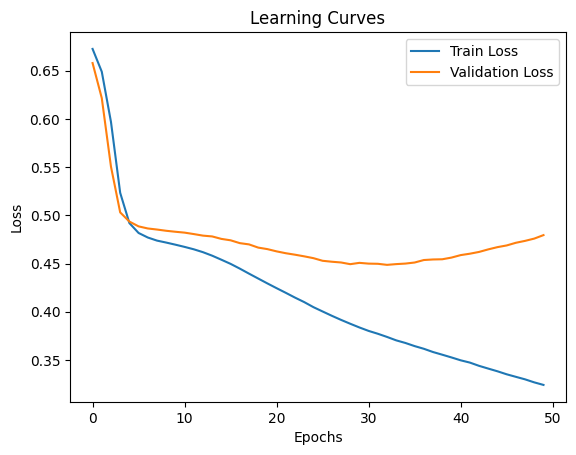



Training with {'criterion': BCELoss(), 'lr': 0.001, 'optimizer': <class 'torch.optim.sgd.SGD'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 0.6719093322753906


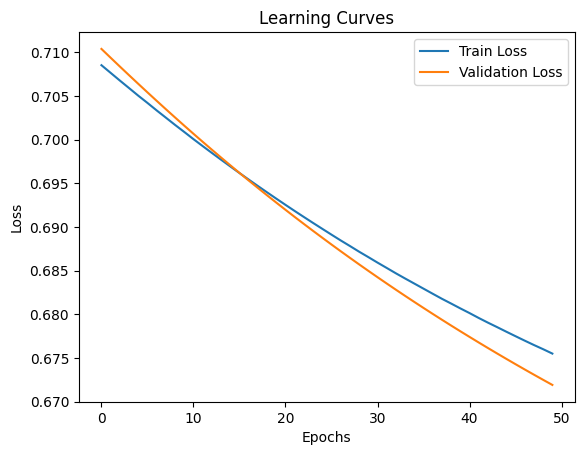



Training with {'criterion': BCELoss(), 'lr': 0.01, 'optimizer': <class 'torch.optim.adam.Adam'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 1.234199047088623


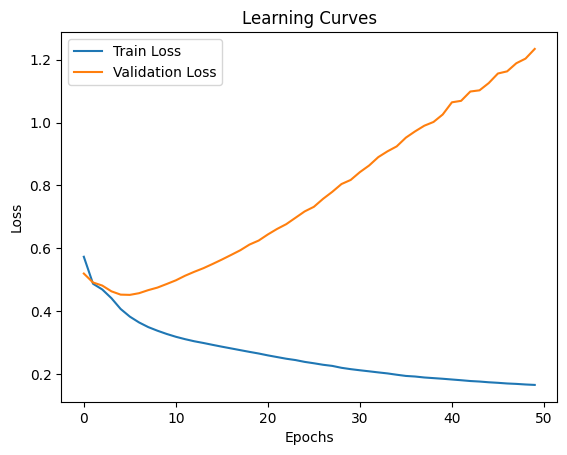



Training with {'criterion': BCELoss(), 'lr': 0.01, 'optimizer': <class 'torch.optim.sgd.SGD'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 0.6171562671661377


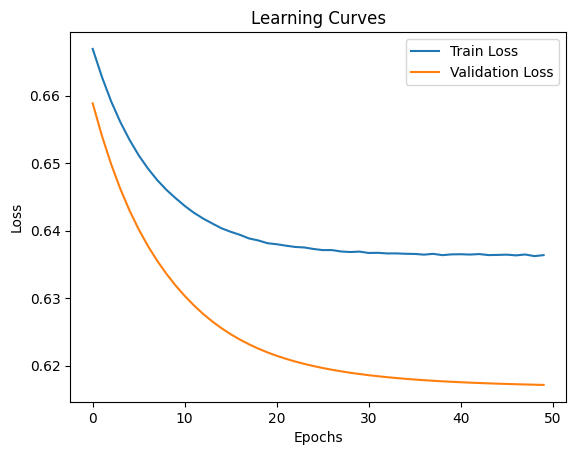



Training with {'criterion': BCELoss(), 'lr': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 1.0445902347564697


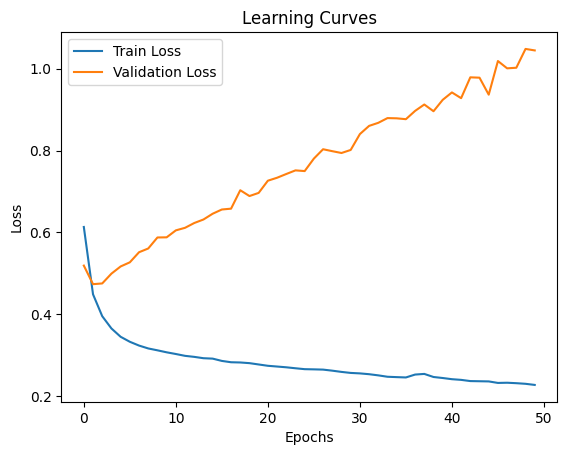



Training with {'criterion': BCELoss(), 'lr': 0.1, 'optimizer': <class 'torch.optim.sgd.SGD'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 0.6162328720092773


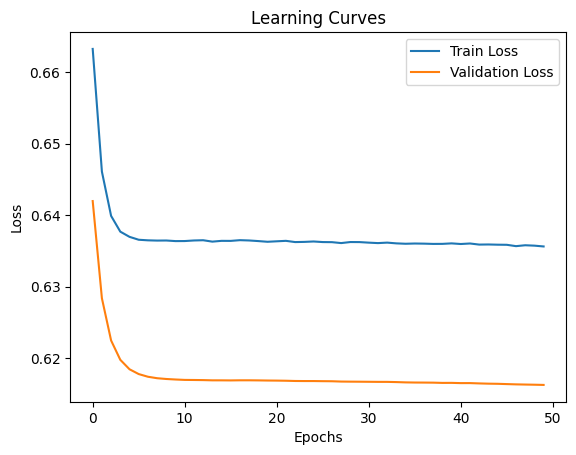



Training with {'criterion': MSELoss(), 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 0.15578439831733704


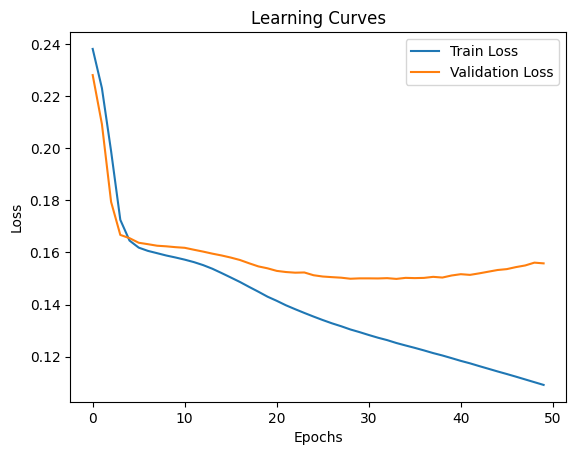



Training with {'criterion': MSELoss(), 'lr': 0.001, 'optimizer': <class 'torch.optim.sgd.SGD'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 0.24908773601055145


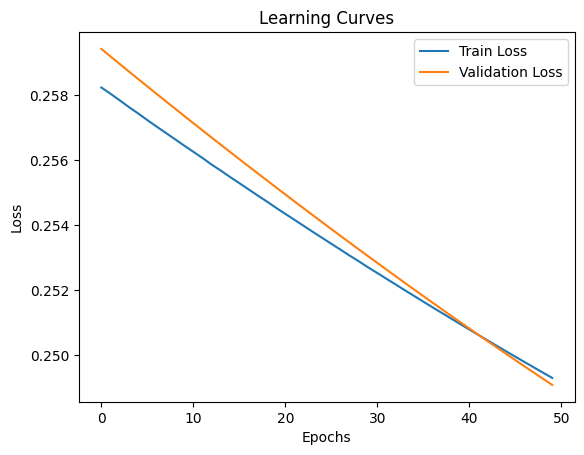



Training with {'criterion': MSELoss(), 'lr': 0.01, 'optimizer': <class 'torch.optim.adam.Adam'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 0.23362264037132263


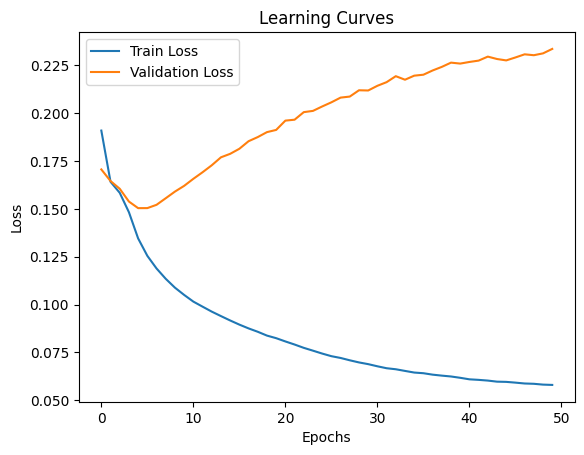



Training with {'criterion': MSELoss(), 'lr': 0.01, 'optimizer': <class 'torch.optim.sgd.SGD'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 0.21702098846435547


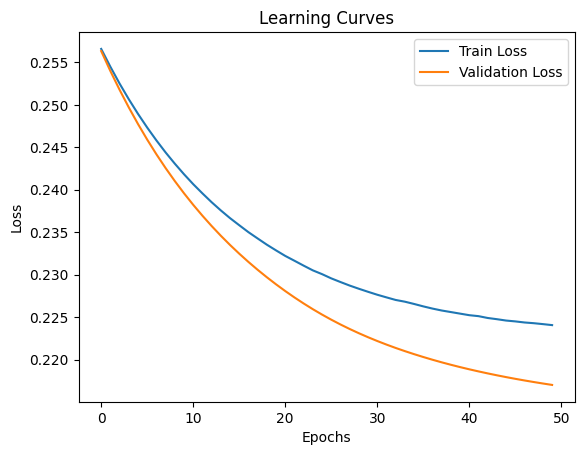



Training with {'criterion': MSELoss(), 'lr': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 0.21890480816364288


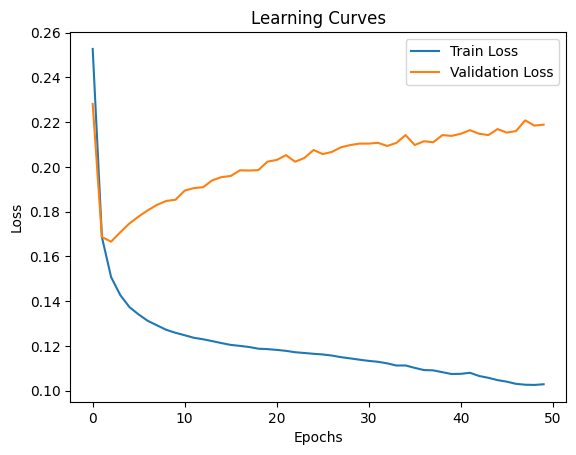



Training with {'criterion': MSELoss(), 'lr': 0.1, 'optimizer': <class 'torch.optim.sgd.SGD'>}
Training 1
Training 10
Training 20
Training 30
Training 40
Training 50
Final Test Loss: 0.2127755582332611


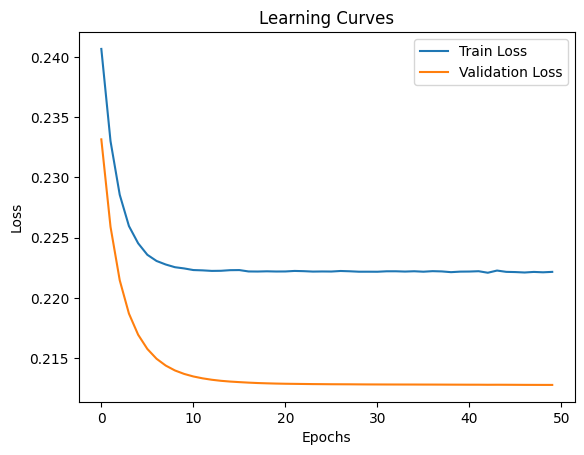



Best Model: NeuMF(
  (mf_user_embed): Embedding(944, 16)
  (mf_item_embed): Embedding(1683, 16)
  (mlp_user_embed): Embedding(944, 64)
  (mlp_item_embed): Embedding(1683, 64)
  (mlp): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (final): Linear(in_features=48, out_features=1, bias=True)
)
Best Loss: 0.15578439831733704
Best Params: {'criterion': MSELoss(), 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}


In [26]:
param_grid = ParameterGrid({
    'criterion': [nn.BCELoss(), nn.MSELoss()],
    'optimizer': [torch.optim.Adam, torch.optim.SGD],
    'lr': [0.001, 0.01, 0.1],
})

users_num = 943 + 1
movies_num = 1682 + 1

best_model = None
best_loss = float('inf')

for params in param_grid:
    print(f'\n\nTraining with {params}')

    criterion = params['criterion']
    Optimizer = params['optimizer']
    lr = params['lr']

    model = NeuMF(users_num,movies_num,16,[128,64,32])
    optimizer = Optimizer(model.parameters(), lr=lr)

    model, train_losses, test_losses = train_model(criterion, optimizer, num_epochs=50)

    final_loss = test_losses[-1]
    print(f'Final Test Loss: {final_loss}')

    if final_loss < best_loss:
        best_loss = final_loss
        best_model = model
        best_params = params
        
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

print(f'\n\nBest Model: {best_model}')
print(f'Best Loss: {best_loss}')
print(f'Best Params: {best_params}')

### Finding the Best Hyperparameters (With Cross Validation)

- Adam and SGD Optimizers
- LR: [0.001, 0.01, 0.1]
- BCE and MSE Loss Functions



Training with {'criterion': BCELoss(), 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.4647989869117737


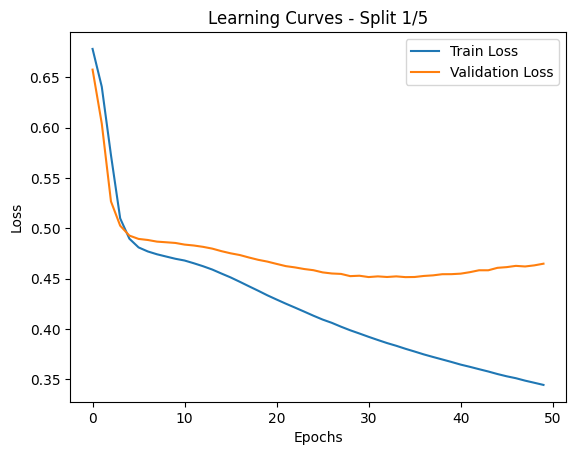


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.4591763913631439


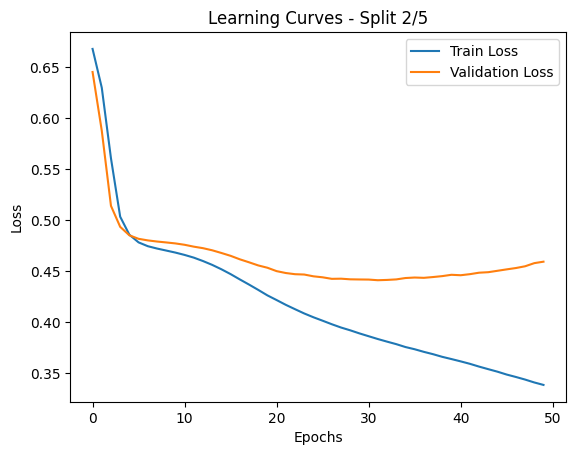


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.44904059171676636


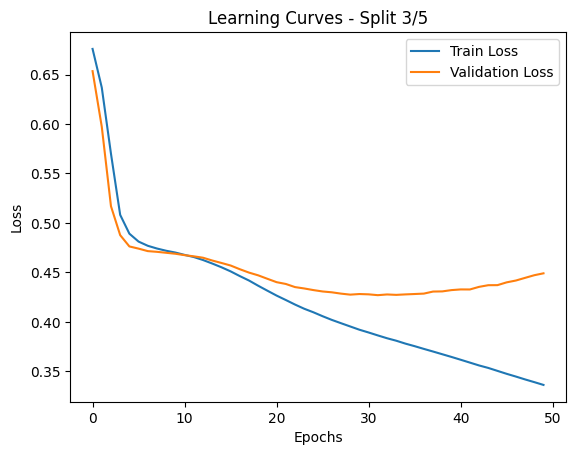


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.45273053646087646


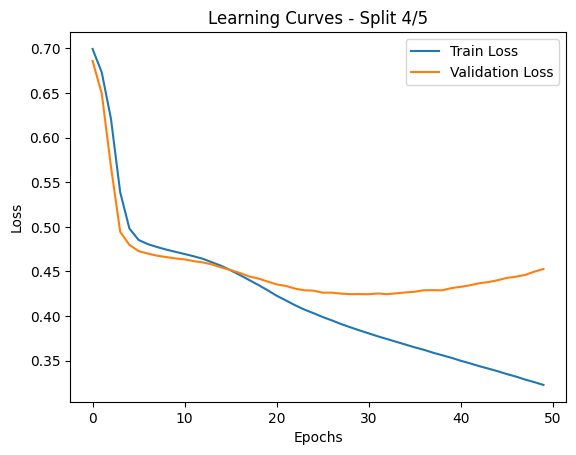


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.4461154639720917


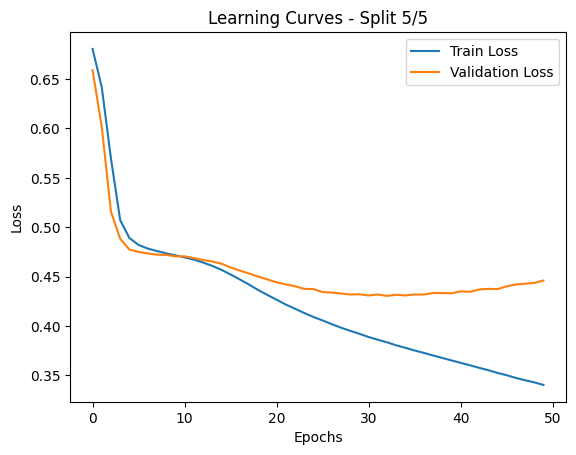



Training with {'criterion': BCELoss(), 'lr': 0.001, 'optimizer': <class 'torch.optim.sgd.SGD'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6650438904762268


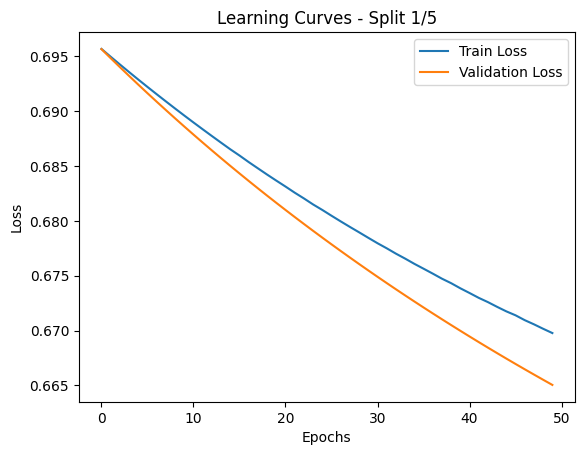


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6473655700683594


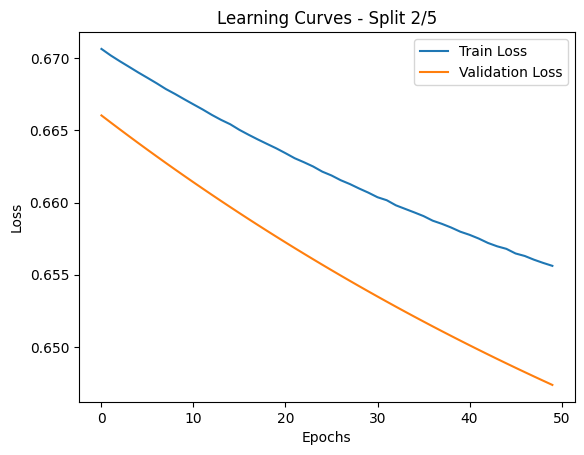


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6586688756942749


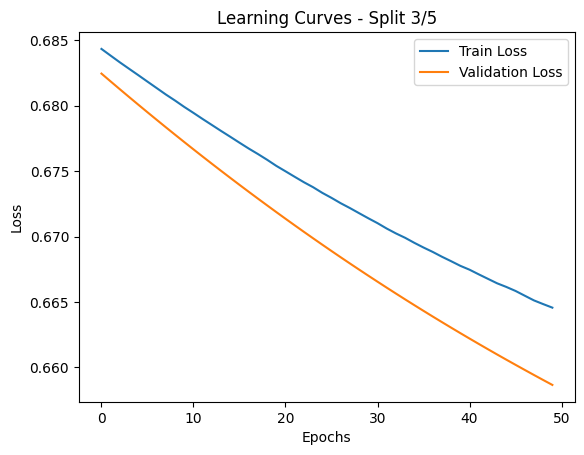


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6767565608024597


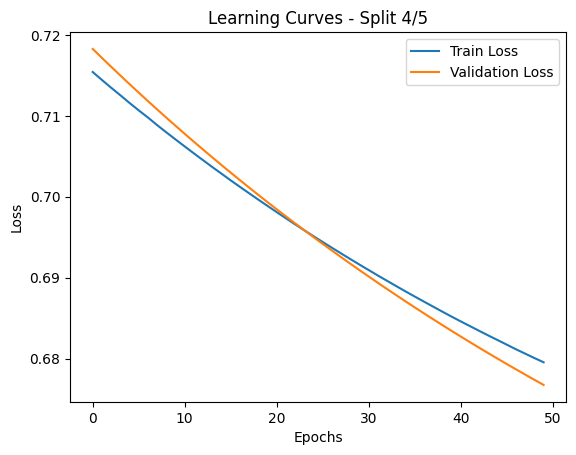


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6731555461883545


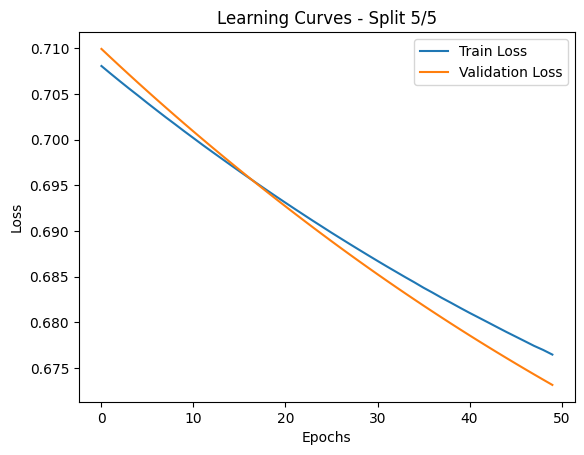



Training with {'criterion': BCELoss(), 'lr': 0.01, 'optimizer': <class 'torch.optim.adam.Adam'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 1.2164064645767212


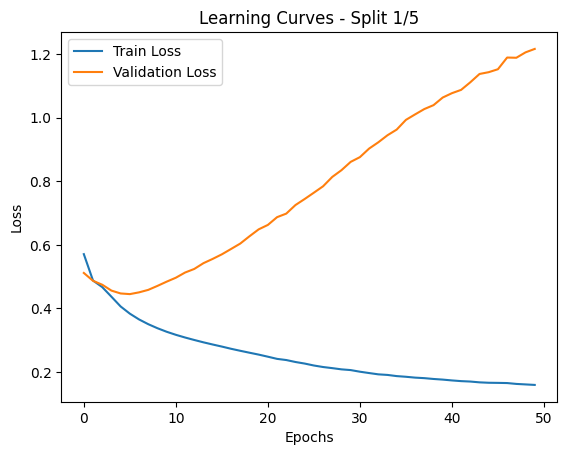


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 1.1912932395935059


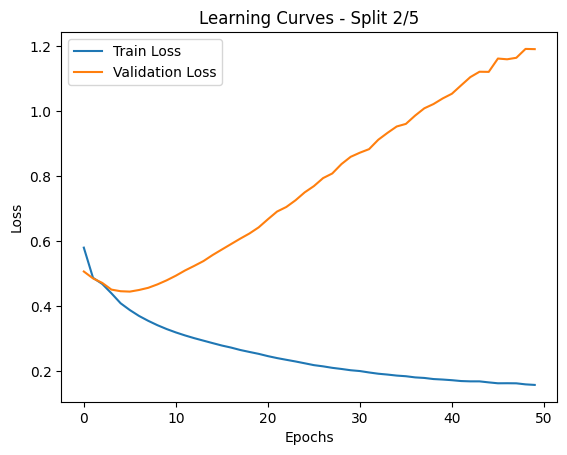


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 1.1306087970733643


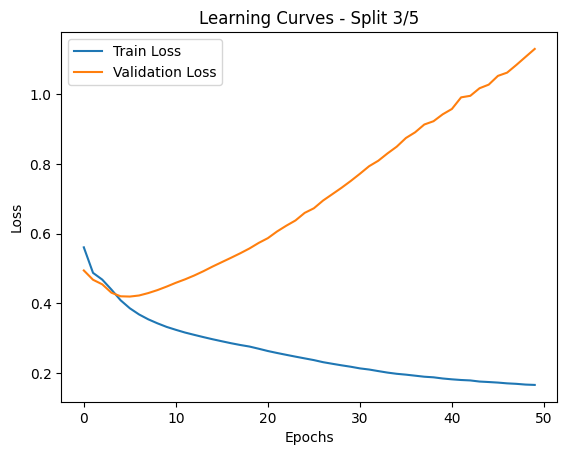


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 1.1317003965377808


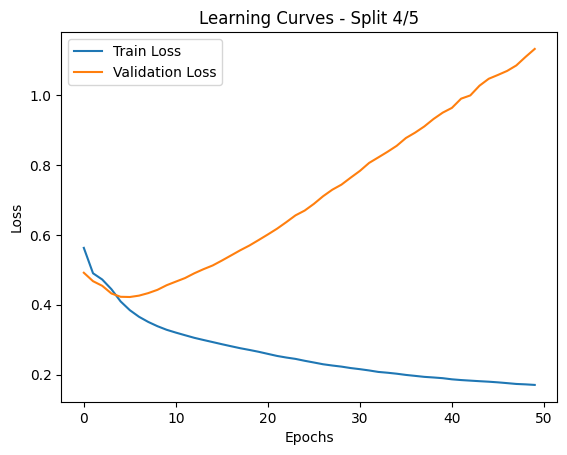


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 1.2525014877319336


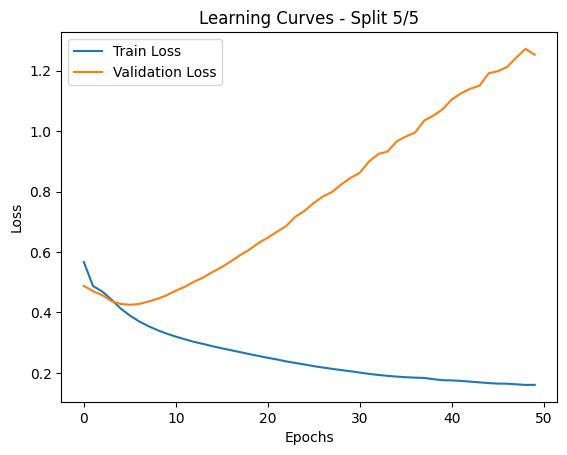



Training with {'criterion': BCELoss(), 'lr': 0.01, 'optimizer': <class 'torch.optim.sgd.SGD'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6177198886871338


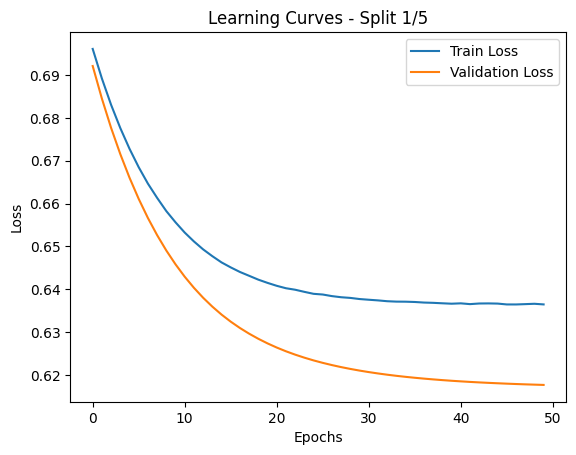


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6178994178771973


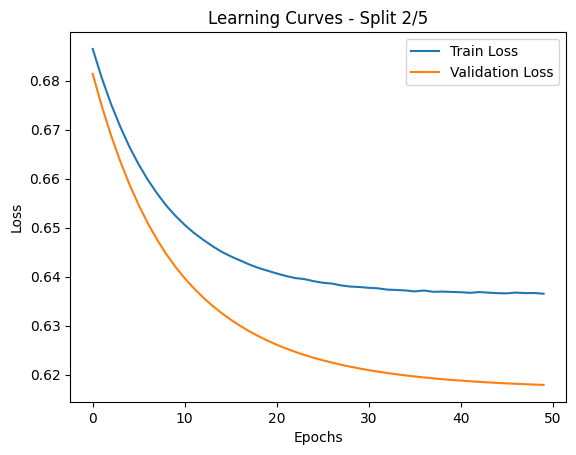


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6180450916290283


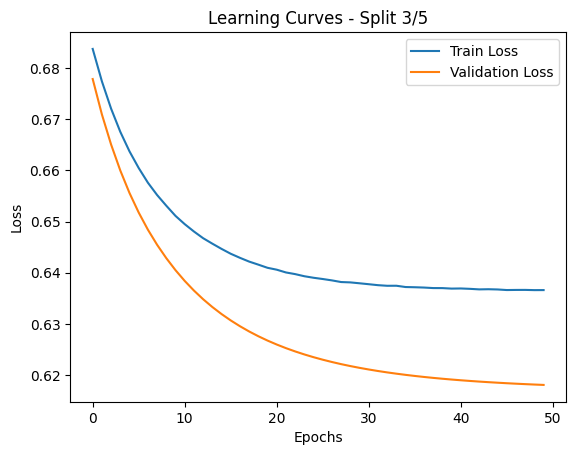


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6173391342163086


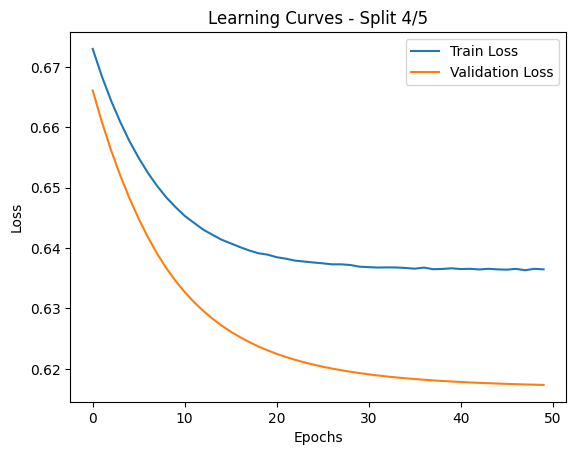


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.618354320526123


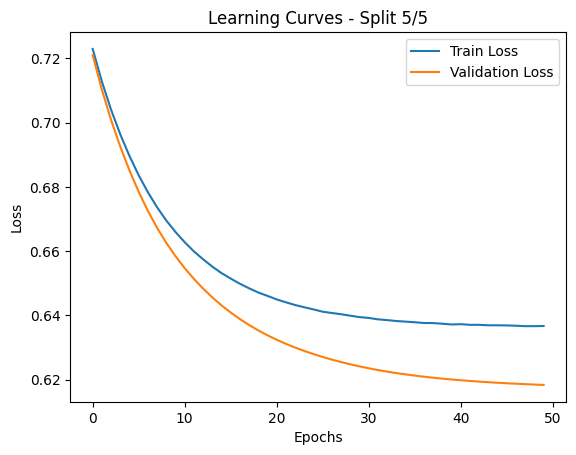



Training with {'criterion': BCELoss(), 'lr': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 1.178389072418213


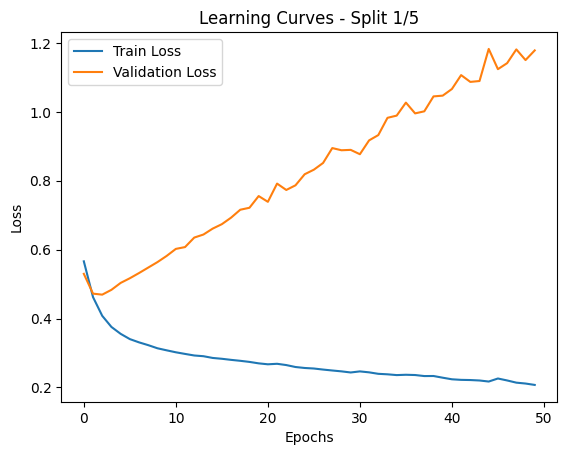


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 1.0313166379928589


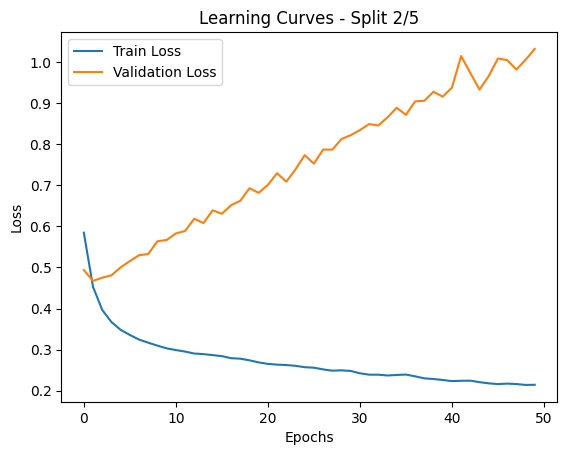


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.9875916838645935


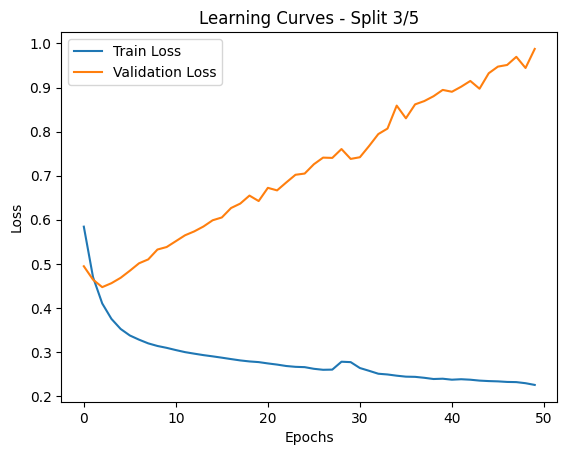


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 1.040597915649414


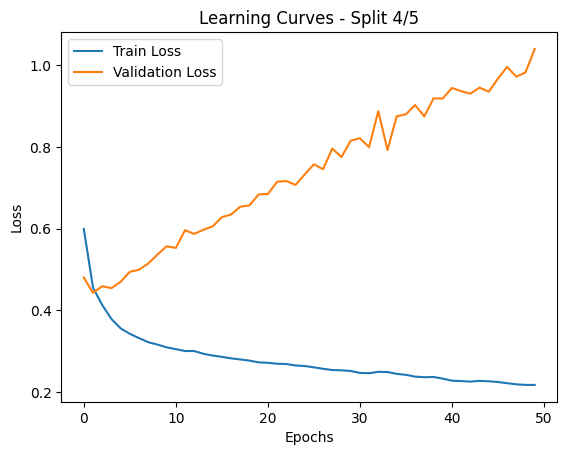


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.9563686847686768


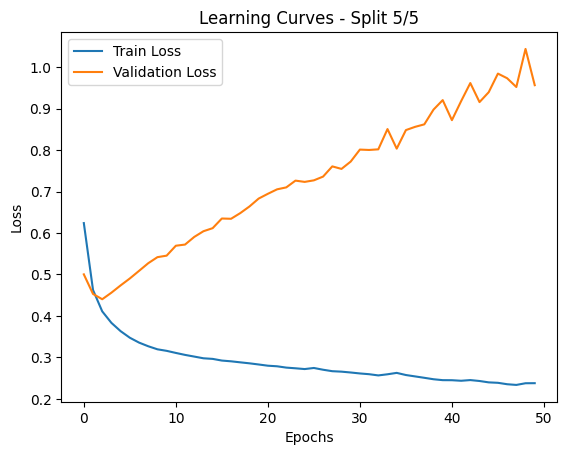



Training with {'criterion': BCELoss(), 'lr': 0.1, 'optimizer': <class 'torch.optim.sgd.SGD'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.616208016872406


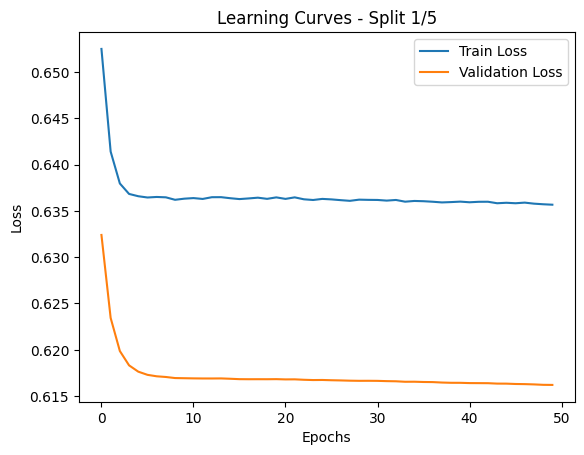


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6152213215827942


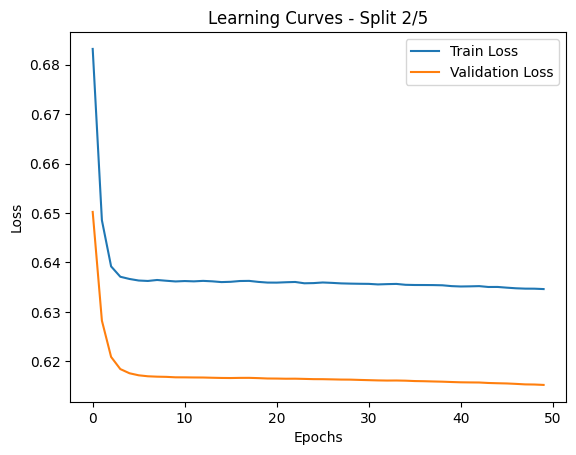


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6165522336959839


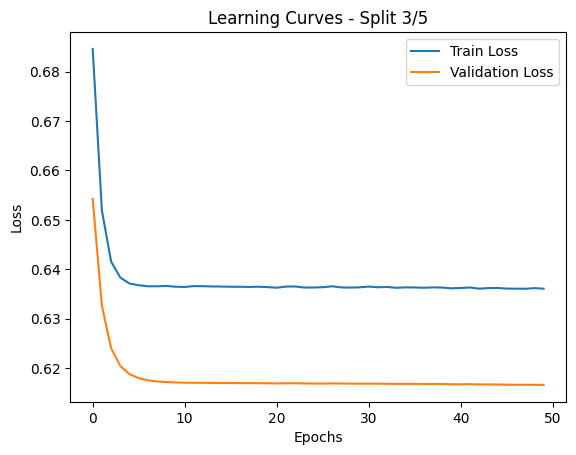


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.615394115447998


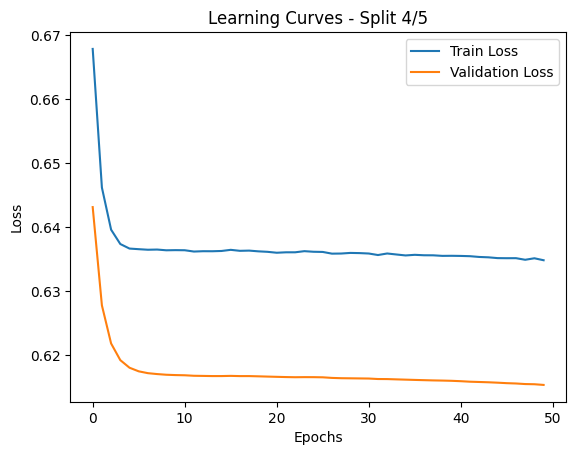


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.6162624359130859


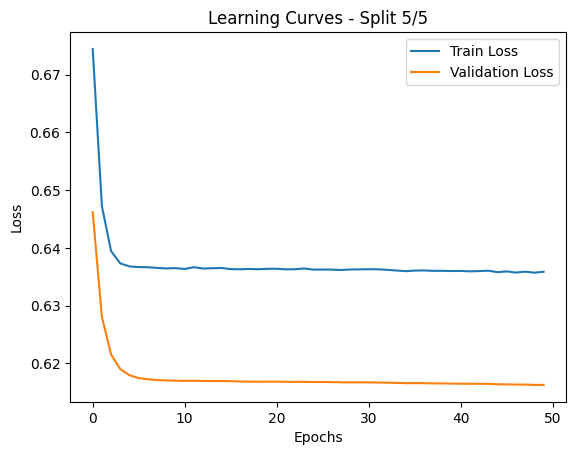



Training with {'criterion': MSELoss(), 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.15468038618564606


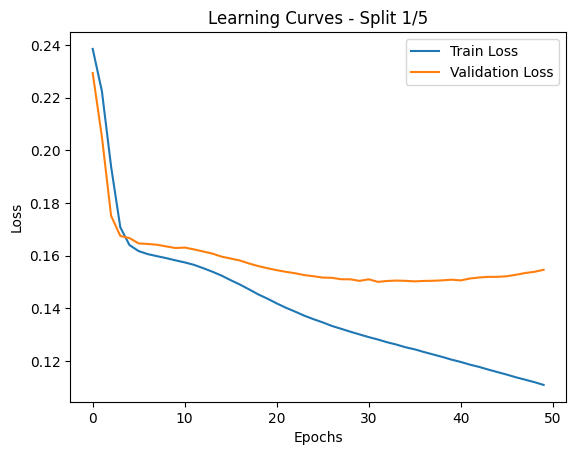


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.15167689323425293


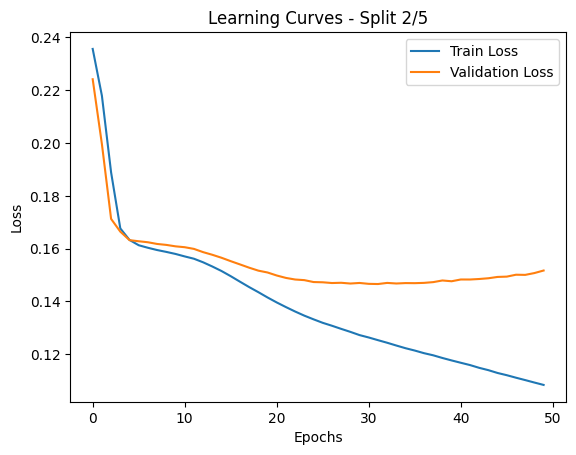


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.14712193608283997


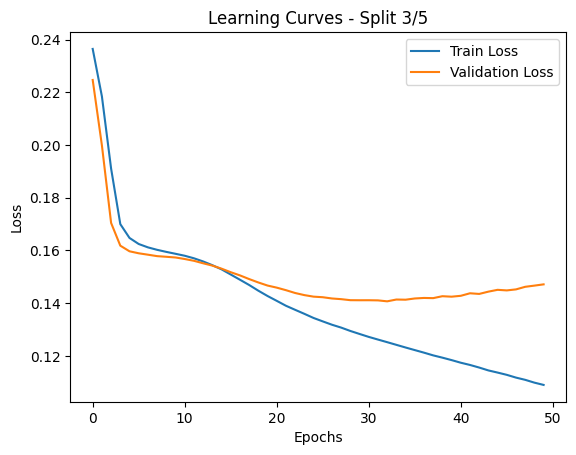


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.14336760342121124


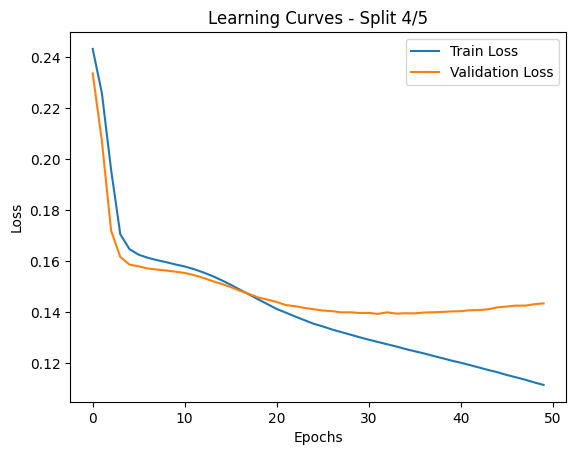


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.14384214580059052


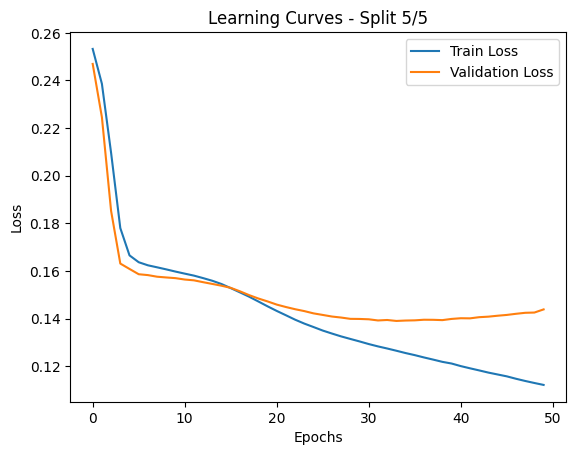



Training with {'criterion': MSELoss(), 'lr': 0.001, 'optimizer': <class 'torch.optim.sgd.SGD'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.24261116981506348


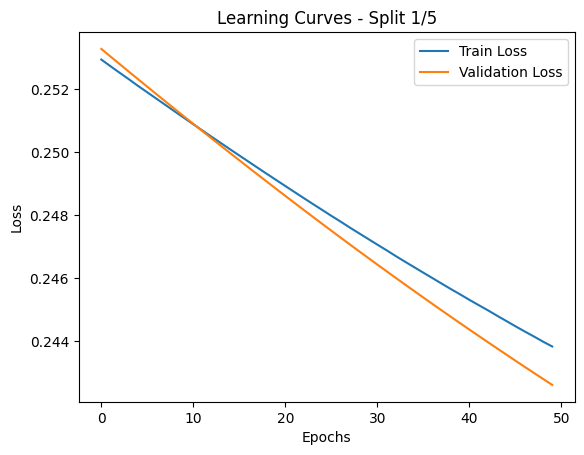


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.23720794916152954


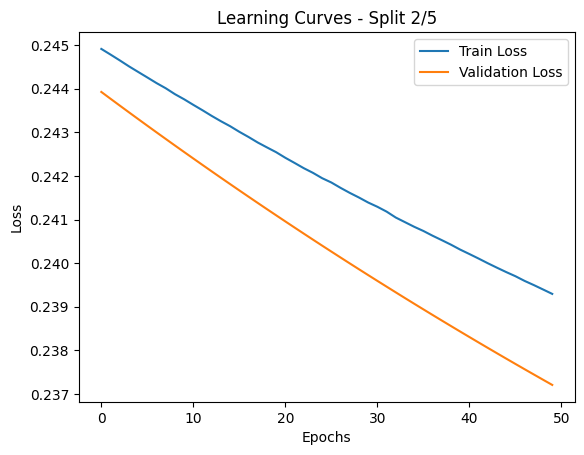


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.24520166218280792


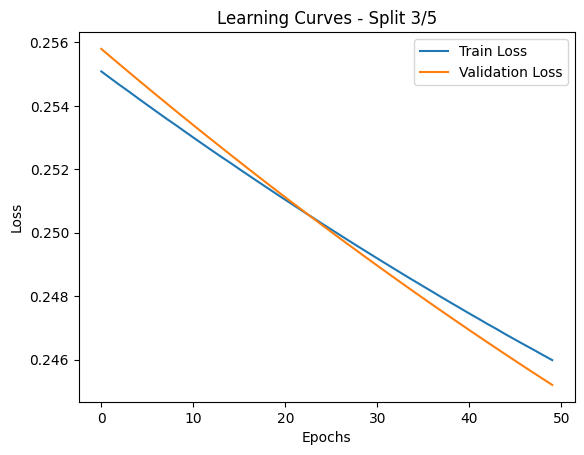


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.2455076277256012


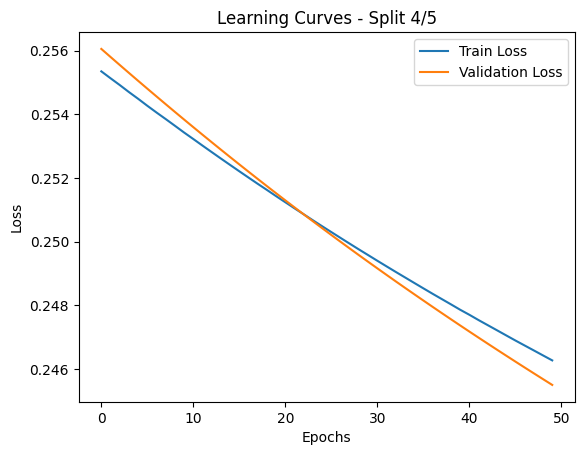


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.24699537456035614


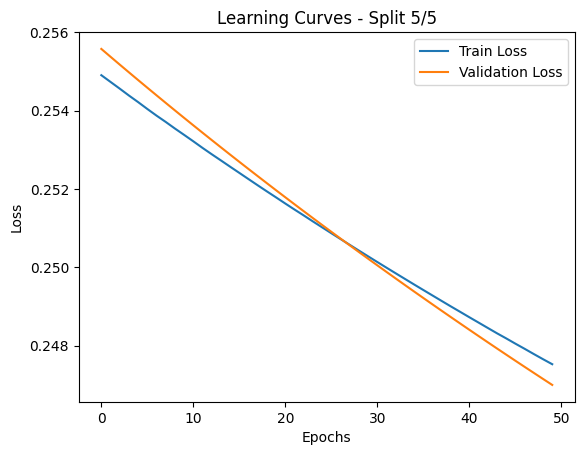



Training with {'criterion': MSELoss(), 'lr': 0.01, 'optimizer': <class 'torch.optim.adam.Adam'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.23500849306583405


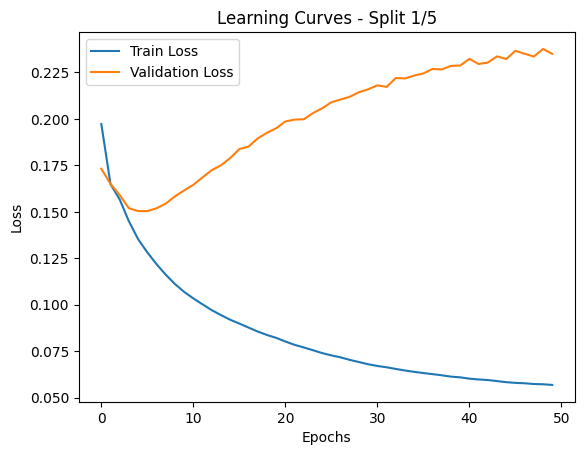


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.22717705368995667


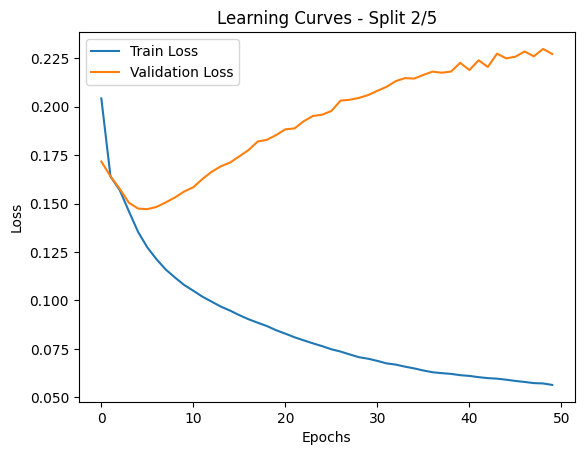


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.2193513810634613


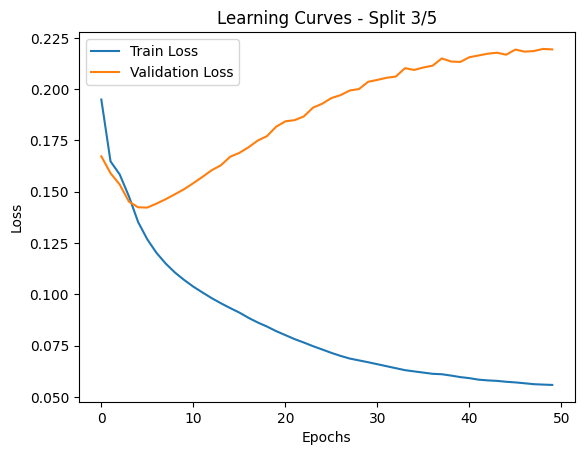


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.21619677543640137


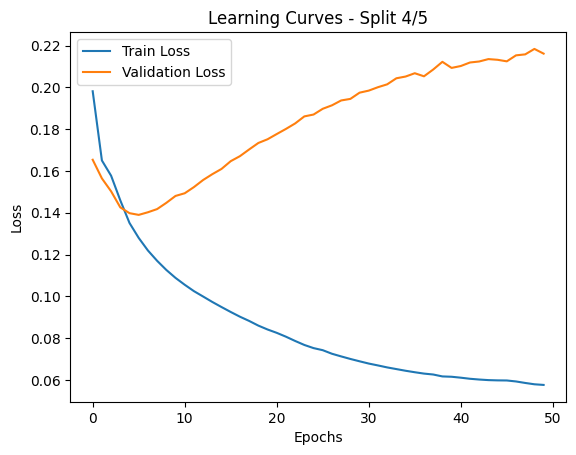


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.21878637373447418


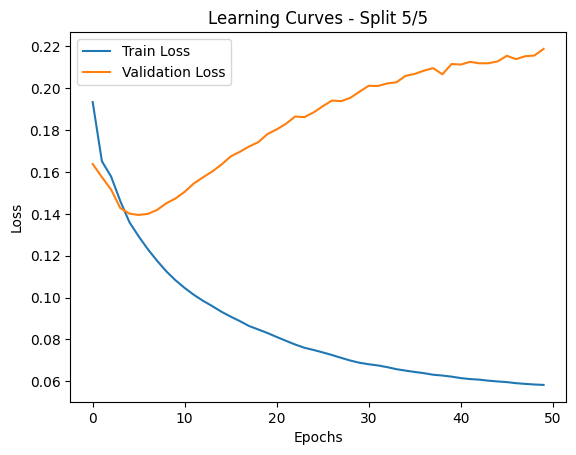



Training with {'criterion': MSELoss(), 'lr': 0.01, 'optimizer': <class 'torch.optim.sgd.SGD'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.21452608704566956


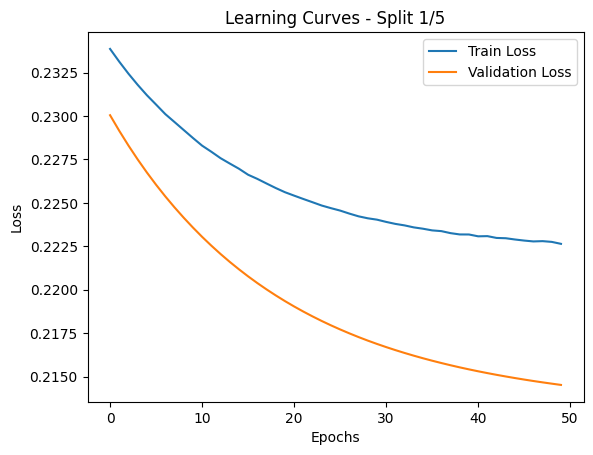


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.21643635630607605


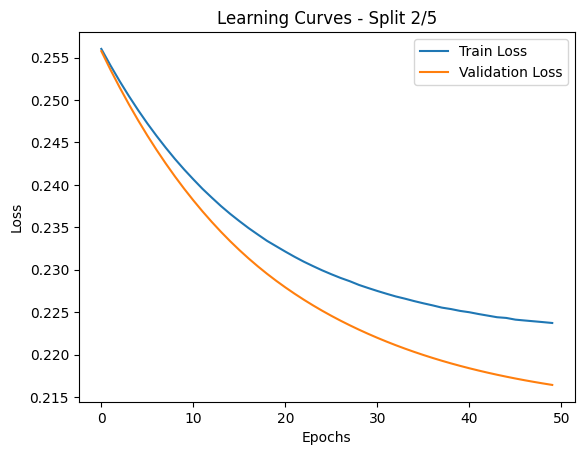


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.21803508698940277


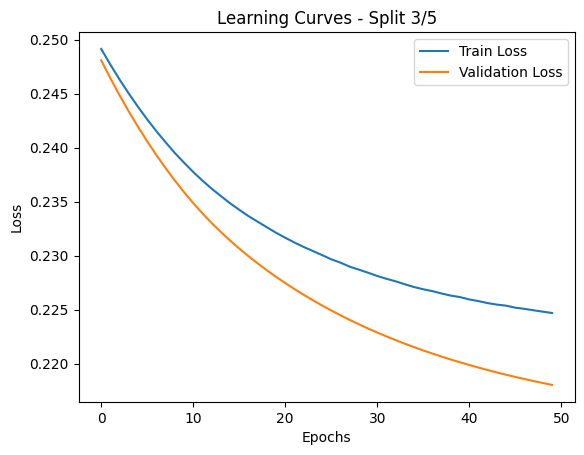


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.21623018383979797


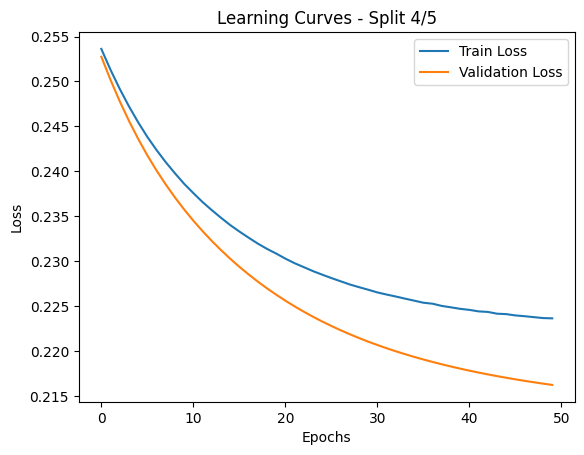


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.2167268693447113


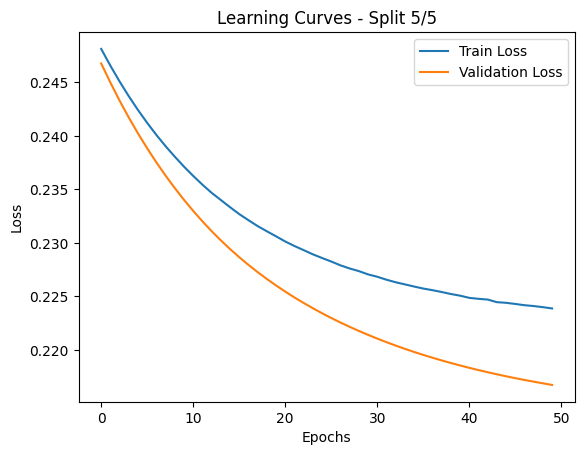



Training with {'criterion': MSELoss(), 'lr': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.24071359634399414


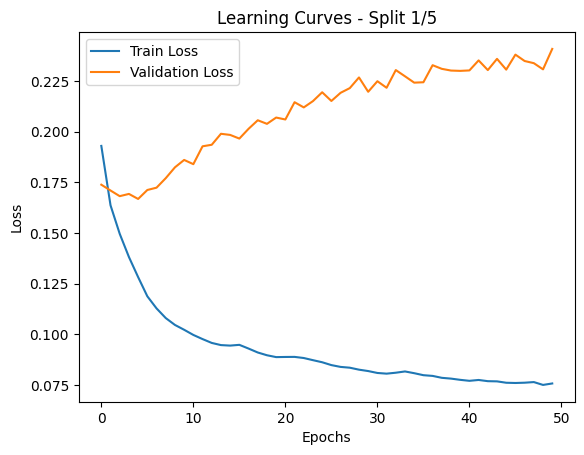


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.2065022885799408


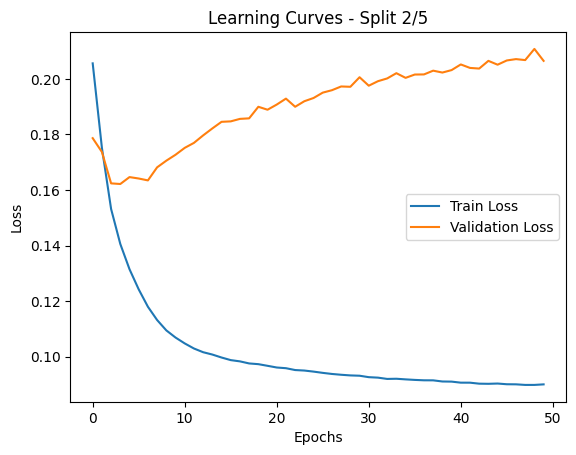


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.1979966163635254


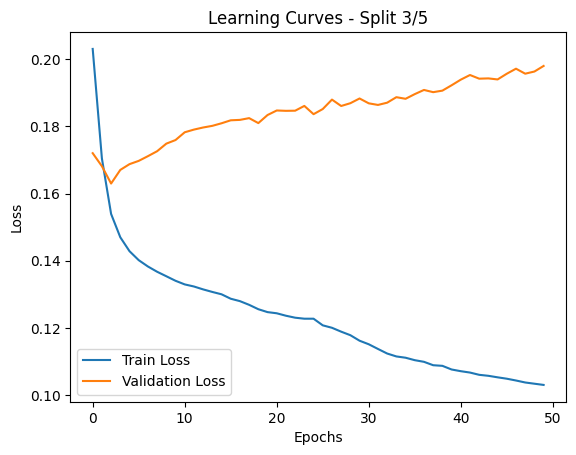


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.20967045426368713


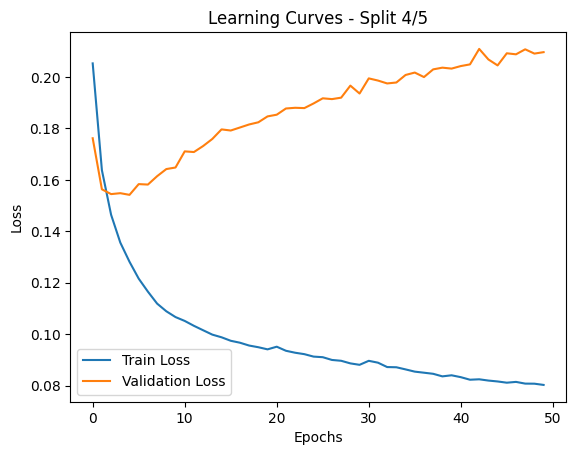


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.21657657623291016


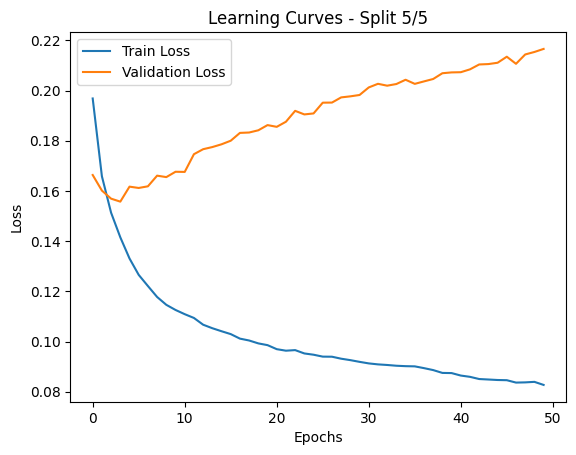



Training with {'criterion': MSELoss(), 'lr': 0.1, 'optimizer': <class 'torch.optim.sgd.SGD'>}

Processing split 1/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.2127133309841156


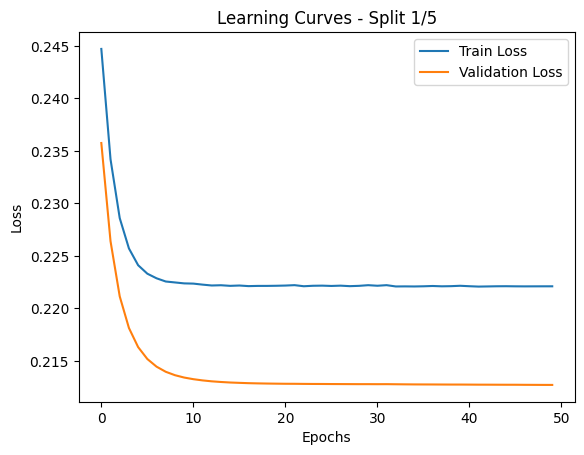


Processing split 2/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.2126382738351822


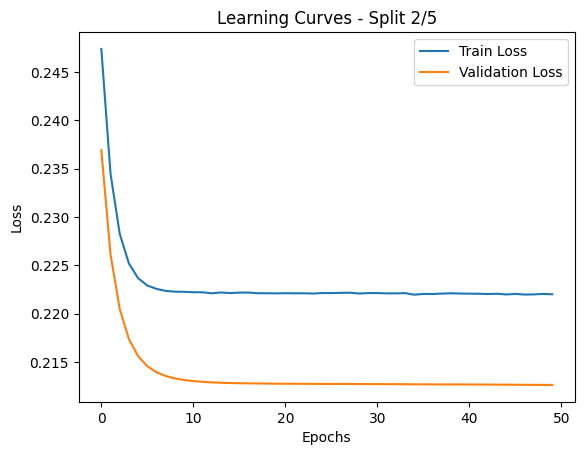


Processing split 3/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.21272341907024384


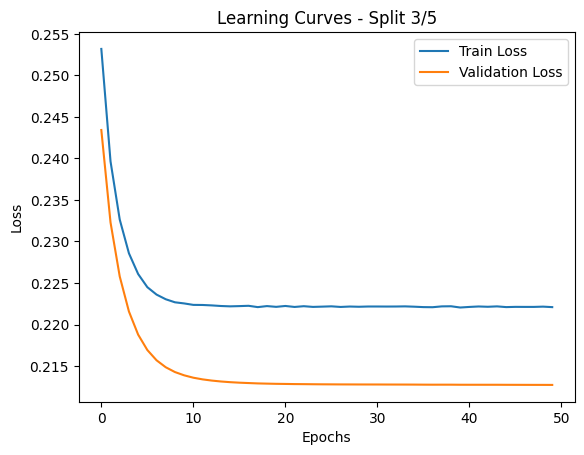


Processing split 4/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.2127915471792221


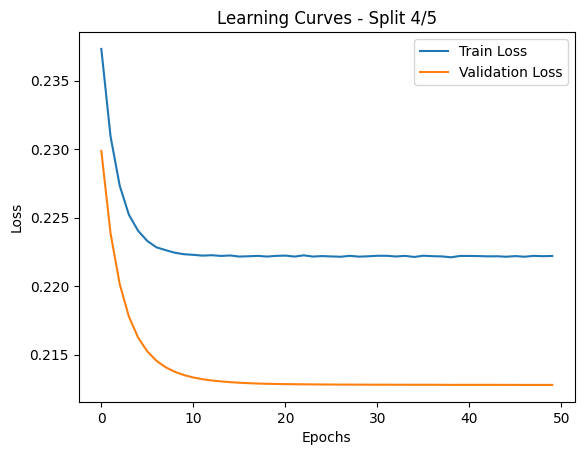


Processing split 5/5
Epoch 1
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Final Test Loss: 0.21271194517612457


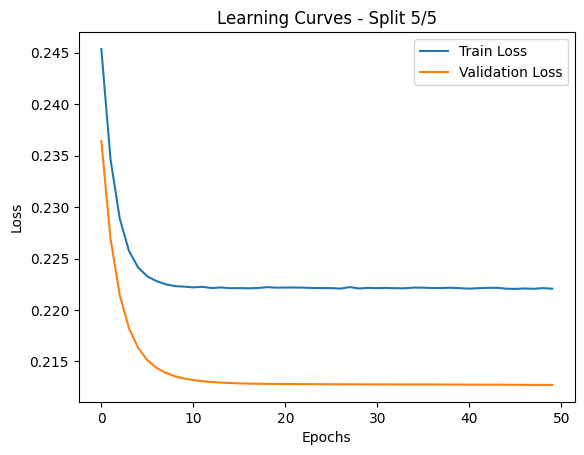



Best Model: NeuMF(
  (mf_user_embed): Embedding(944, 16)
  (mf_item_embed): Embedding(1683, 16)
  (mlp_user_embed): Embedding(944, 64)
  (mlp_item_embed): Embedding(1683, 64)
  (mlp): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (final): Linear(in_features=48, out_features=1, bias=True)
)
Best Loss: 0.14813779294490814
Best Params: {'criterion': MSELoss(), 'lr': 0.001, 'optimizer': <class 'torch.optim.adam.Adam'>}


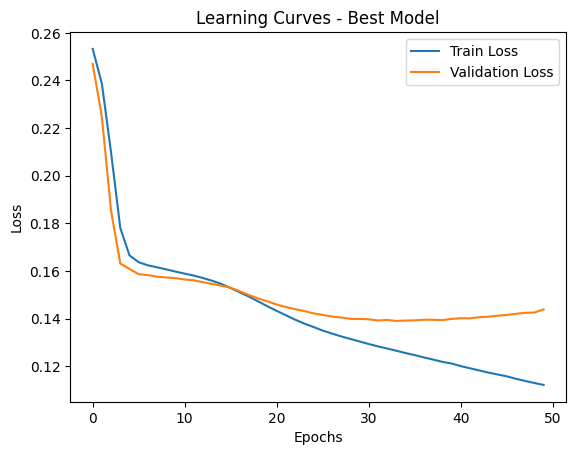

In [9]:
param_grid = ParameterGrid({
    'criterion': [nn.BCELoss(), nn.MSELoss()],
    'optimizer': [torch.optim.Adam, torch.optim.SGD],
    'lr': [0.001, 0.01, 0.1],
})

users_num = 943 + 1
movies_num = 1682 + 1

best_model = None
best_loss = float('inf')
best_train_losses = None
best_test_losses = None

n_splits = 5

for params in param_grid:
    print(f'\n\nTraining with {params}')

    criterion = params['criterion']
    Optimizer = params['optimizer']
    lr = params['lr']

    test_losses_per_split = []

    for i in range(n_splits):
        print(f'\nProcessing split {i + 1}/{n_splits}')

        model = NeuMF(users_num, movies_num, 16, [128,64,32])
        optimizer = Optimizer(model.parameters(), lr=lr)

        model, train_losses, test_losses = train_model(criterion, optimizer, train_file=f'ml-100k/u{i+1}.base', test_file=f'ml-100k/u{i+1}.test', num_epochs=50)

        final_loss = test_losses[-1]

        print(f'Final Test Loss: {final_loss}')

        test_losses_per_split.append(final_loss)

        plt.figure()
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Learning Curves - Split {i + 1}/{n_splits}')
        plt.legend()
        plt.show()

    avg_test_loss = np.mean(test_losses_per_split)

    if avg_test_loss < best_loss:
        best_loss = avg_test_loss
        best_model = model
        best_params = params
        best_train_losses = train_losses
        best_test_losses = test_losses

print(f'\n\nBest Model: {best_model}')
print(f'Best Loss: {best_loss}')
print(f'Best Params: {best_params}')

plt.figure()
plt.plot(best_train_losses, label='Train Loss')
plt.plot(best_test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves - Best Model')
plt.legend()
plt.show()


### Conclusions:

In both scenarios, with and without cross-validation, the optimal hyperparameters were found to be the Mean Squared Error (*MSE*) as the loss function, *Adam* as the optimizer, and a learning rate of *0.001*.

However, the performance of the model differs slightly in each case:

1. <b>Without cross-validation:</b> The best model achieved a minimum loss value of 0.15578. This indicates that the model, on average, has a mean squared error of 0.15578 when predicting movie ratings.

2. <b>With cross-validation:</b> The best model achieved a slightly lower loss value of 0.14813. Cross-validation generally provides a more reliable assessment of the model's performance, as it trains and evaluates the model on different subsets of the data. The lower loss indicates that, on average, the model's predictions are closer to the actual ratings when using cross-validation.


And regarding when model overfiting, as it is shown in the learning curve above, the model learns effectively from the training data, as evidenced by the decreasing training loss. However, overfitting starts to occur <b>after the 32nd epoch</b>, as shown by the increasing test loss. Therefore, to prevent overfitting and improve the model's generalizability to unseen data, we could consider stopping the training around the 32nd epoch, where the test loss reaches its minimum.

### Your task
1. Find best HP of the model by crossvalidation
2. for every user provide the recommendation, calculate HR@10 (as in the previous excersise)